### This notebooks demonstrates the Frank-Wolfe Algorithm on Two Examples

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(631)
np.set_printoptions(precision=5, suppress=True)

In [116]:
def generate_data(m, n, s, sigma = 0.1):
    # Generate X from Gaussian distribution
    X = np.random.randn(m, n)

    # Create beta_star with first s entries as 1 and the rest 0
    beta_star = np.zeros(n)
    beta_star[:s] = np.ones(s)

    y = X @ beta_star + sigma * np.random.randn(m)

    return X, y, beta_star

In [117]:
# Evaluate the error
def l2_error(beta, beta_star):
    return np.linalg.norm(beta - beta_star)

In [118]:
def plot_results(iterates, objective_values, beta_opt):
    # Calculate the errors between iterates and beta_opt
    errors = [l2_error(beta_t, beta_opt) for beta_t in iterates]

    # Create Figure 1: Error vs. Iteration
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(errors)
    plt.xlabel('Iteration')
    plt.ylabel(r'Error: $\|\beta_t - \beta^*\|_2$')
    plt.title('Error vs. Iteration')

    # Create Figure 2: Objective Function Value vs. Iteration
    plt.subplot(1, 2, 2)
    plt.plot(objective_values)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function Value vs. Iteration')

    plt.tight_layout()
    plt.show()

In [119]:
m, n, s = 100, 50, 10  # m samples, n features, s sparsity
X, y, beta_star = generate_data(m, n, s)

In [120]:
def solve_lasso(lambda_val, X, y):
    m, n = X.shape

    beta_cvx = cp.Variable(n)

    objective = cp.Minimize(cp.norm2(y - X @ beta_cvx)**2)
    constraints = [cp.norm(beta_cvx, 1) <= lambda_val]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return beta_cvx.value

In [123]:
beta_opt = solve_lasso(10, X, y)

print(f"L1-constrained problem -- Error of Convex optimization from CVXPY: \n{l2_error(beta_star, beta_opt)}")

if l2_error(beta_star, beta_opt) < 0.1:
  print("\nThis method recovers the parameter acurrately.\n")
else:
  print("\nThe error seems a bit large.")

L1-constrained problem -- Error of Convex optimization from CVXPY: 
0.06728299565496375

This method recovers the parameter acurrately.



In [124]:
print(beta_opt)
print(beta_star)

[ 0.99727  0.99335  0.99898  1.00255  1.00016  0.99387  0.98814  0.96616
  0.9846   0.95985 -0.       0.      -0.00318  0.       0.       0.
  0.      -0.00745 -0.00409 -0.       0.      -0.00083 -0.0056   0.00111
  0.01352  0.      -0.00166 -0.00162 -0.      -0.      -0.       0.
 -0.      -0.0047  -0.00392  0.       0.       0.00574 -0.0122   0.
  0.      -0.      -0.      -0.00971  0.      -0.      -0.       0.0099
 -0.02314  0.00669]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


L1-constrained problem -- Error of Projected gradient: 
0.04176855307947633


Projected Gradient recovers the parameter acurrately 



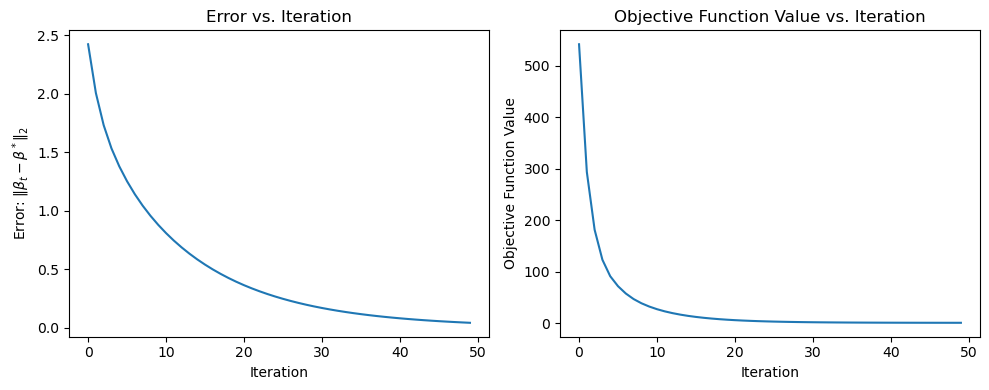

In [128]:
def project_lasso(beta, lambda_val):
    beta_proj = cp.Variable(n)

    objective = cp.Minimize(cp.norm2(beta - beta_proj)**2)
    constraints = [cp.norm1(beta_proj) <= lambda_val]

    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return beta_proj.value


def projected_gradient_lasso(beta_0, X, y, alpha, lambda_, N_iter):
    # Initialize variables
    beta = beta_0
    objective_values = []  # To store the sequence of objective values
    iterates = []  # To store the sequence of iterates (beta values)

    for _ in range(N_iter):
        # Compute the gradient of the objective function
        gradient = -2 * X.T.dot(y - X.dot(beta))

        # Update beta using projection of (beta - alpha * gradient)
        beta = project_lasso(beta - alpha * gradient, lambda_)
        
        # Calculate the objective value and append to the list
        objective_value = np.linalg.norm(y - X.dot(beta))**2
        objective_values.append(objective_value)

        # Append the current iterate (beta) to the list
        iterates.append(beta)

    return beta, iterates, objective_values


## Now let's test projected gradient

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = 0.001
N_iter = 50

beta_proj, beta_proj_seq, func_proj_seq = projected_gradient_lasso(beta_init, X, y, stepsize, lambda_, N_iter)

print(f"L1-constrained problem -- Error of Projected gradient: \n{l2_error(beta_proj, beta_opt)}\n")

if l2_error(beta_proj, beta_opt) < 0.1:
  print("\nProjected Gradient recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large.")

# generate plots
plot_results(beta_proj_seq, func_proj_seq, beta_opt)

In [129]:
print(beta_proj)

[ 0.99015  0.98556  0.98926  1.0037   0.98605  0.98135  0.9992   0.96588
  0.97648  0.95097  0.       0.      -0.01835  0.00025  0.       0.
 -0.      -0.01164 -0.00276 -0.006    0.      -0.00551 -0.00074  0.00004
  0.01519  0.      -0.      -0.00013 -0.00496 -0.      -0.       0.
 -0.      -0.01448 -0.00007 -0.       0.       0.01963 -0.0167   0.
  0.00317 -0.      -0.00759 -0.0088  -0.00111  0.      -0.00661  0.0093
 -0.01257  0.00582]


### Frank-Wolfe Method

In [130]:
def update_direction_lasso(grad, lambda_):
    # Your code here
    target = cp.Variable(len(grad))

    objective = cp.Minimize(target @ grad)
    constraints = [cp.norm1(target) <= lambda_]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return target.value


def frank_wolfe_lasso(beta_0, X, y, alpha, lambda_, N_iter, const_step=True):
    beta = beta_0
    objective_values = []  # To store the sequence of objective values
    iterates = []  # To store the sequence of iterates (beta values)

    for i in range(N_iter):
        # Compute the gradient of the objective function
        gradient = -2 * X.T.dot(y - X.dot(beta))

        # Update direction
        target = update_direction_lasso(gradient, lambda_)
        
        if not const_step:
            alpha = 2 / (i + 2)
        beta = (1-alpha) * beta + alpha * target

        # Calculate the objective value and append to the list
        objective_value = np.linalg.norm(y - X.dot(beta))**2
        objective_values.append(objective_value)

        # Append the current iterate (beta) to the list
        iterates.append(beta)

    return beta, iterates, objective_values


L1-constrained problem -- Error of Frank-Wolfe: 
2.992912059002853


The error seems a bit large.


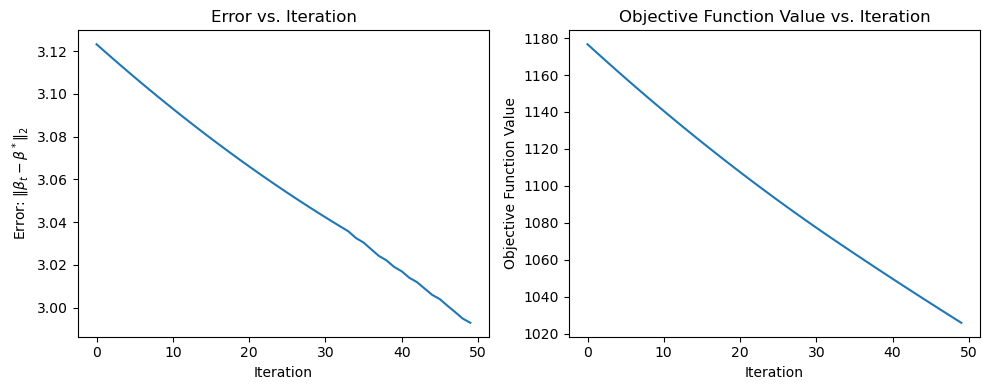

[ 0.       0.       0.       0.38869  0.       0.       0.07929  0.01996
  0.       0.      -0.       0.      -0.       0.       0.       0.
  0.       0.      -0.      -0.       0.       0.       0.      -0.
  0.       0.       0.       0.       0.       0.      -0.       0.
  0.      -0.      -0.      -0.      -0.       0.      -0.       0.
  0.       0.      -0.      -0.      -0.       0.      -0.       0.
  0.       0.     ]


In [132]:
## Now let's test Frank-Wolfe

# initialization
# beta_init = np.zeros(n)
lambda_ = 10
stepsize = 0.001
N_iter = 50
# N_iter = 20000

beta_fw, beta_fw_seq, fun_fw_seq = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=True)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("\nFrank-Wolfe recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large.")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

L1-constrained problem -- Error of Frank-Wolfe: 
0.3477623814824905


The error seems a bit large.


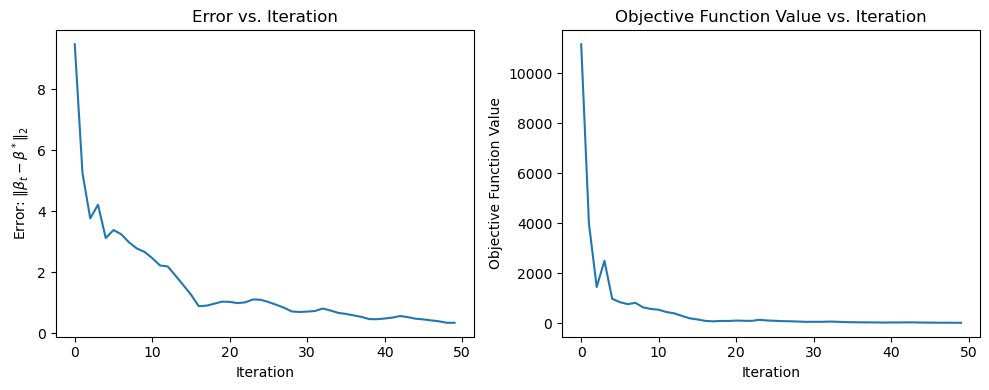

[ 0.95686  0.86275  0.89412  0.9098   0.98824  1.05098  1.12941  0.77647
  1.01961  0.81569 -0.       0.      -0.       0.       0.       0.
  0.      -0.      -0.      -0.       0.       0.       0.      -0.
  0.      -0.       0.      -0.       0.       0.      -0.       0.
 -0.      -0.      -0.      -0.       0.       0.      -0.      -0.
  0.       0.      -0.      -0.      -0.       0.      -0.       0.
 -0.       0.     ]


In [133]:
## Now let's test Frank-Wolfe

# initialization
# beta_init = np.zeros(n)
lambda_ = 10
stepsize = 0.001
N_iter = 50
# N_iter = 20000

beta_fw, beta_fw_seq, fun_fw_seq = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=False)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("\nFrank-Wolfe recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large.")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

L1-constrained problem -- Error of Frank-Wolfe: 
0.06488552478942891


Frank-Wolfe recovers the parameter acurrately 



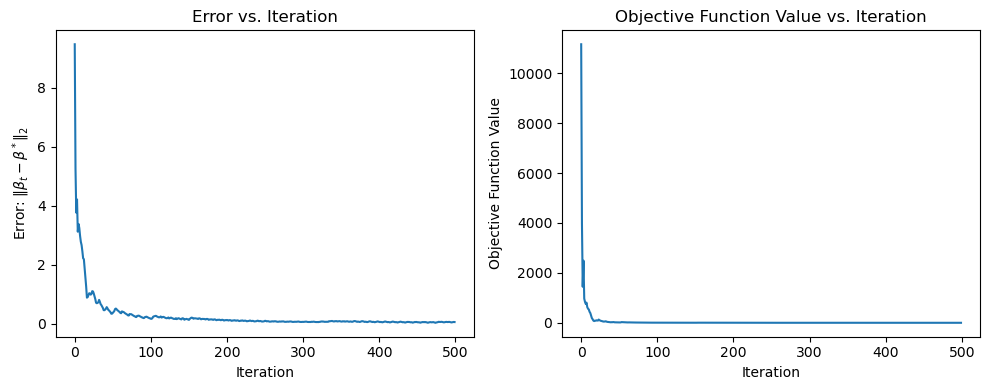

[ 0.98283  1.01038  1.00663  0.9909   0.98507  1.00096  0.96032  0.97852
  0.96383  0.94715 -0.      -0.      -0.       0.       0.       0.
  0.      -0.      -0.      -0.       0.      -0.      -0.       0.
  0.       0.      -0.      -0.       0.      -0.       0.      -0.
 -0.      -0.      -0.       0.       0.       0.       0.00008  0.
  0.      -0.      -0.      -0.      -0.       0.      -0.       0.
 -0.02587  0.03824]


In [139]:
## Now let's test Frank-Wolfe

# initialization
# beta_init = np.zeros(n)
lambda_ = 10
stepsize = 0.001
N_iter = 800
# N_iter = 20000

beta_fw, beta_fw_seq, fun_fw_seq = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=False)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("\nFrank-Wolfe recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large.")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)